In [160]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cmdstanpy
from IPython.display import Image
import arviz as az

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['figure.figsize'] = (11, 7)

bayesian linear regression
statistical model and pgms
priors and likelihood
prior predictive checks
mcmc
posterior samples
posterior predictive checks

# reading models

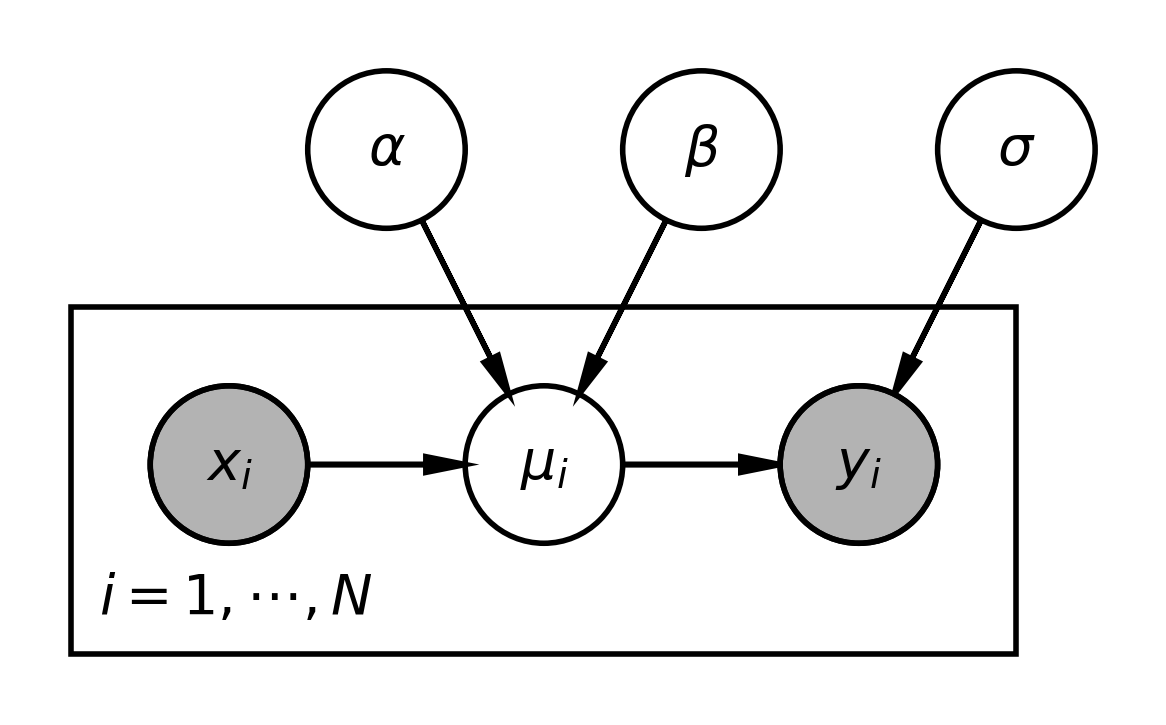

In [12]:
Image("pgm.png", embed=True, width=800, height=700)

### Likelihood (preferred notation):
\begin{align}
    y_i \sim \mathcal{N}(\mu_i, \sigma) \\
    \mu_i = \alpha + \beta \, x_i \\
\end{align}
### or:
\begin{align}
    y_i = \mu_i + \epsilon_i \\
    \epsilon_i \sim \mathcal{N}(0, \sigma) \\
\end{align}

### Priors:
\begin{align}
    \alpha \sim \mathcal{N}(0, 1) \\
    \beta \sim \mathcal{N}(0, 1) \\
    \sigma \sim Exp\,(1) \\
\end{align}

Text(0, 0.5, 'y')

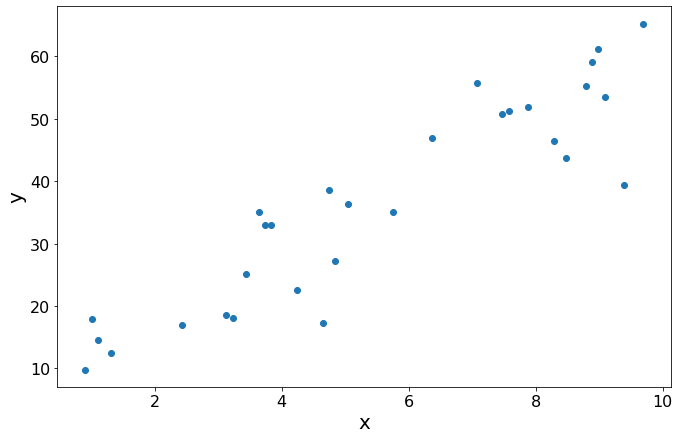

In [164]:
# generate some data
x = np.random.choice(np.linspace(0, 10, 100), size=30, replace=False)
x = np.sort(x)
n = len(x)

# true values that we want to recover
a = 10
b = 5
s = 7

# simulate some observations
mu = a + b * x
y = np.random.normal(mu, s)

# clamp at 0, maybe y is something physical that can't be negative (e.g. weight, height)
y = np.maximum(y, 0)

# plot the data
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')

# choosing priors

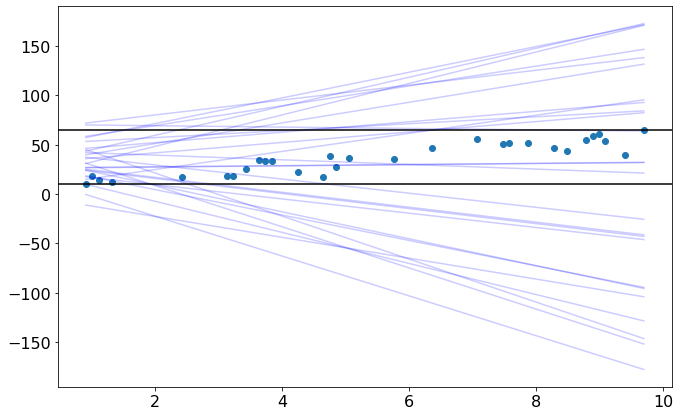

In [165]:
# see if our priors are reasonable

n_sim = 25
x_range = np.linspace(x.min(), x.max())

beta_sim = np.random.normal(0, 10, size=n_sim)
alpha_sim = np.random.normal(35, 15, size=n_sim)

for i in range(n_sim):
    plt.plot(x, alpha_sim[i] + beta_sim[i] * x, c='b', alpha=0.2)
    
plt.axhline(y.min(), c='k')
plt.axhline(y.max(), c='k')
plt.scatter(x, y)

Some of the possibilities are completely unreasonable (either way outside the range of what we observe or unphysical). We also put equal probability on positive and negative slopes (with zero slope meaning that there is no relationship between x and y). We should probably pick better priors!

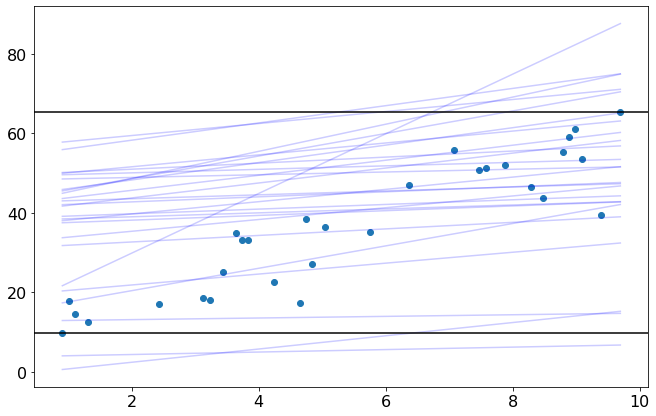

In [166]:
# see if our priors are reasonable

n_sim = 25
x_range = np.linspace(x.min(), x.max())

beta_sim = np.random.lognormal(0.1, 1, size=n_sim)
alpha_sim = np.random.normal(35, 15, size=n_sim)

for i in range(n_sim):
    plt.plot(x, alpha_sim[i] + beta_sim[i] * x, c='b', alpha=0.2)
    
plt.axhline(y.min(), c='k')
plt.axhline(y.max(), c='k')
plt.scatter(x, y)

# talk about mcmc here

In [172]:
# compile stan model
sm = cmdstanpy.CmdStanModel(stan_file = 'linreg.stan')

INFO:cmdstanpy:compiling stan program, exe file: /home/js/programs/linreg-bayes/linreg
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/js/programs/linreg-bayes/linreg


In [173]:
# prep data to be passed in to stan model
data = {
    'N': n,
    'x': x,
    'y': y,
}

In [191]:
# sample posterior
fit = sm.sample(data, show_progress='notebook')

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

In [192]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-77.0,0.034,1.30,-79.0,-76.0,-75.0,1400.0,17000.0,1.0
alpha,8.7,0.076,2.90,4.1,8.5,14.0,1500.0,18000.0,1.0
beta,5.1,0.012,0.48,4.3,5.1,5.8,1500.0,18000.0,1.0
sigma,7.3,0.024,1.10,5.8,7.1,9.2,2000.0,23000.0,1.0


In [193]:
# get posterior samples
alphas = fit.stan_variable('alpha')
betas = fit.stan_variable('beta')
sigmas = fit.stan_variable('sigma')

# pairs plots

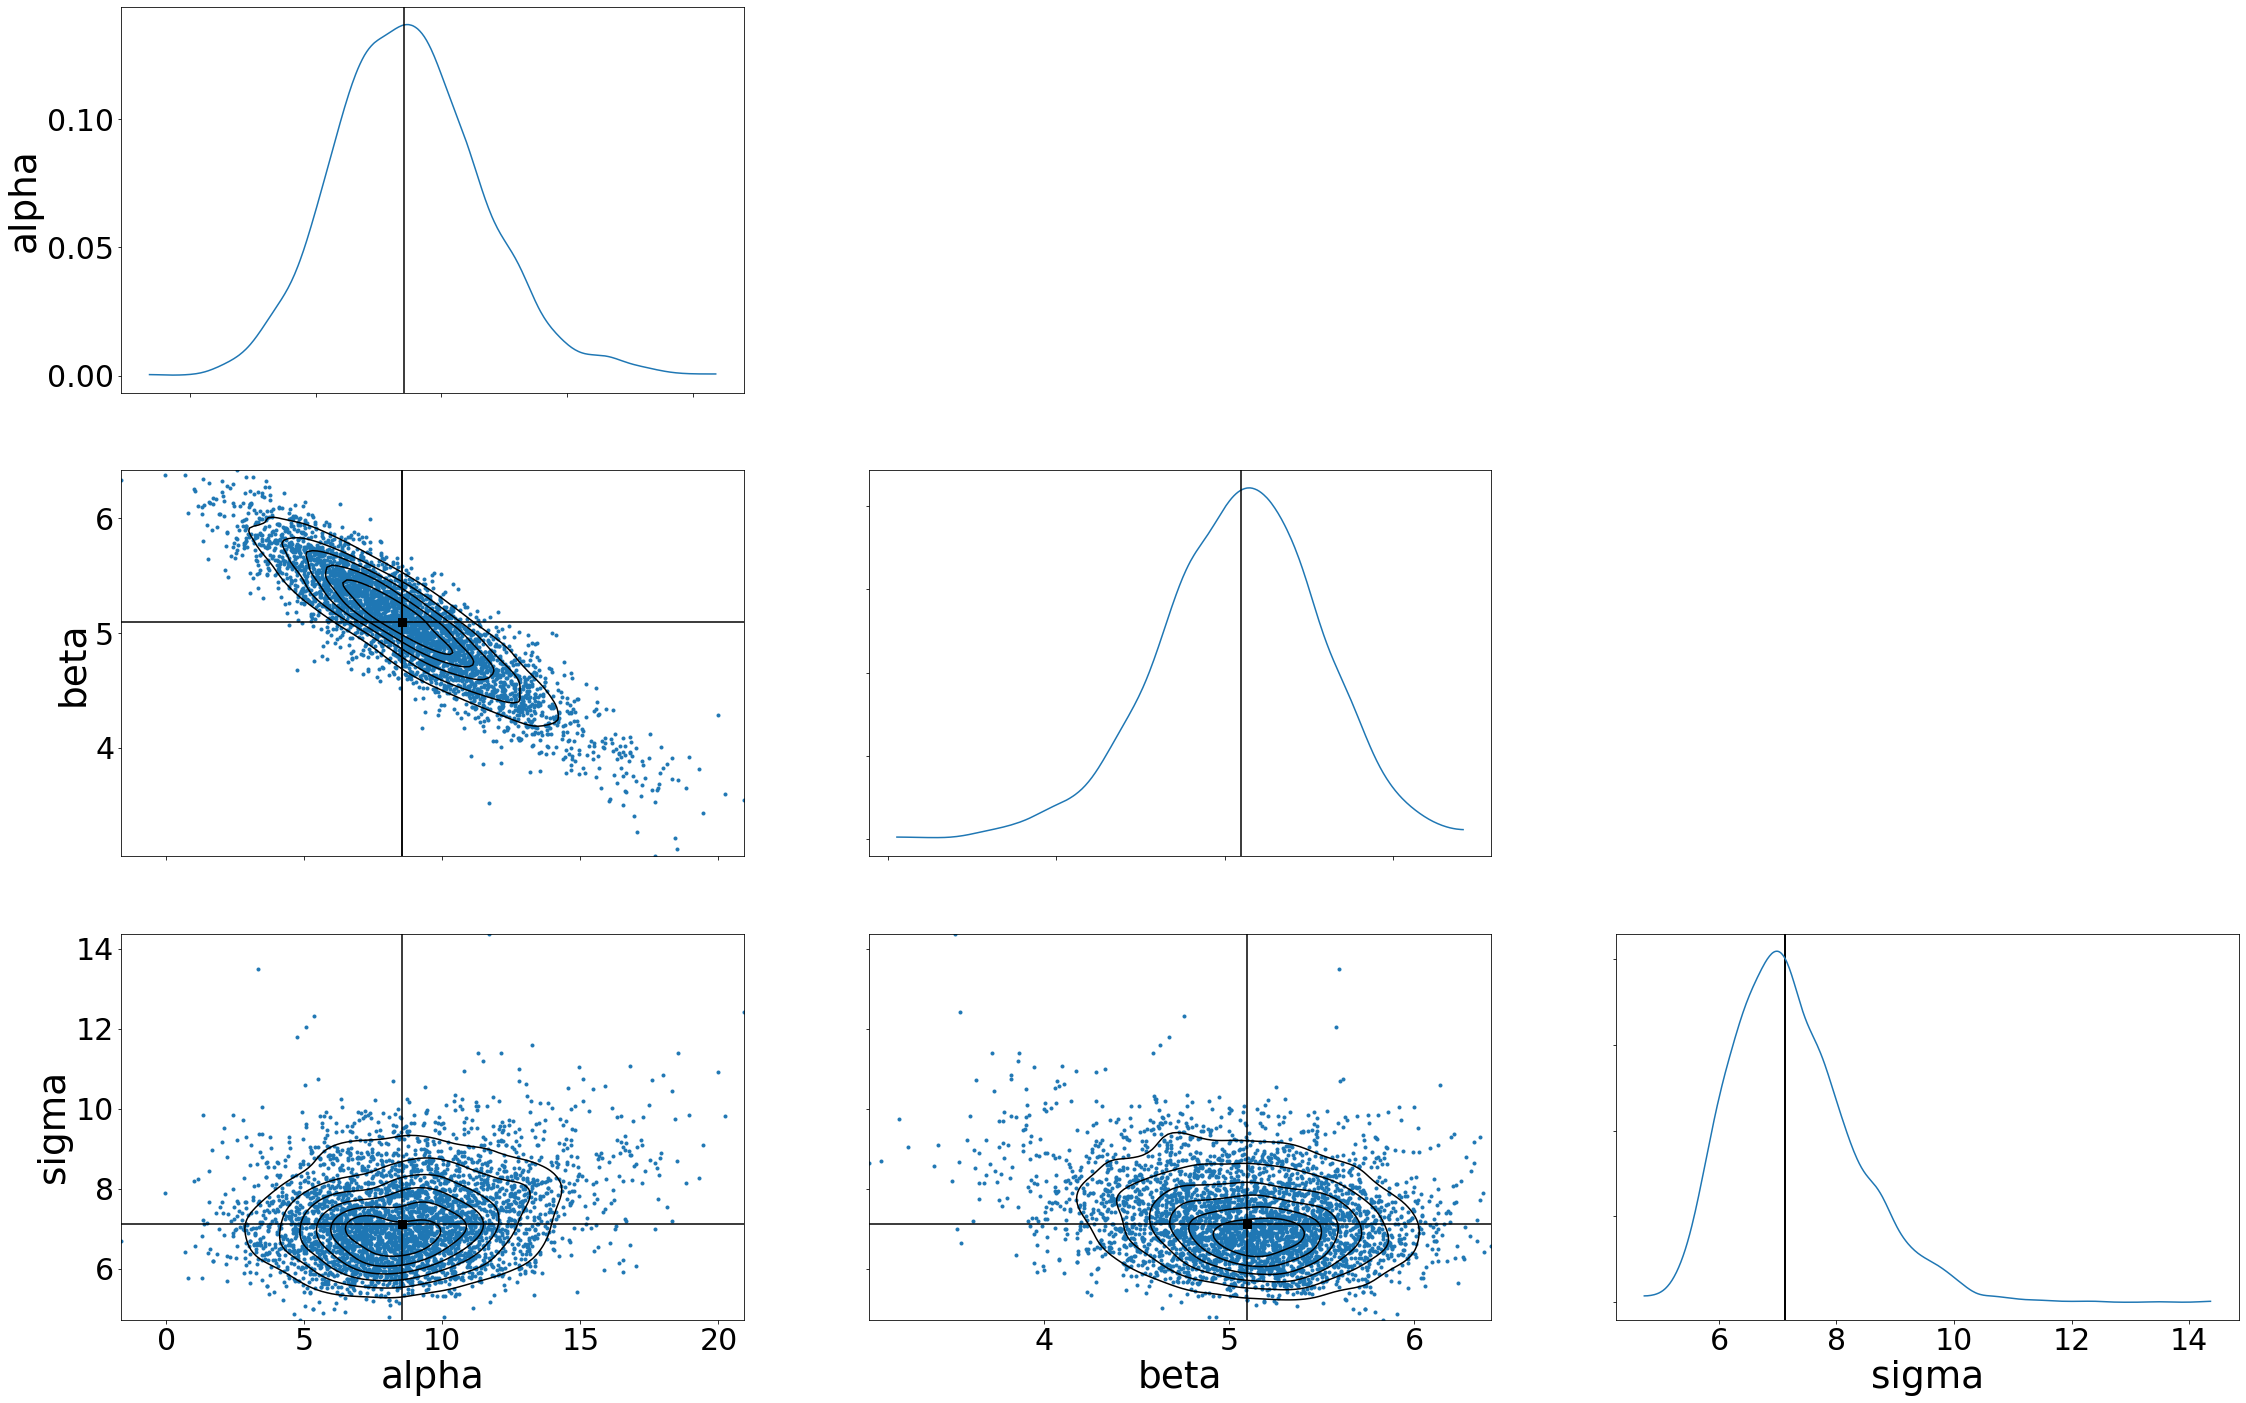

In [194]:
az.plot_pair(fit, var_names=['alpha', 'beta', 'sigma'], marginals=True, kind=['scatter', 'kde'], point_estimate='median', textsize=30);